### TYK2 IL-23 RNA-seq Assay Combined Analysis

In [3]:
library(ggpubr)
library(DESeq2)
library(ggcorrplot)
library(furrr)
library(ggbiplot)
library(patchwork)
library(ComplexHeatmap)
library(tidyverse)

#### Dataset Properties <a name="part1"></a>

In [4]:
alignments <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_star.txt") %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

count_summary <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_featureCounts.txt")  %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

Rows: 80 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): insertion_length, num_GCAG_splices, multimapped_toomany_percent, i...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 80 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (16): Unassigned_Secondary, Unassigned_FragmentLength, Unassigned_Chimer...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


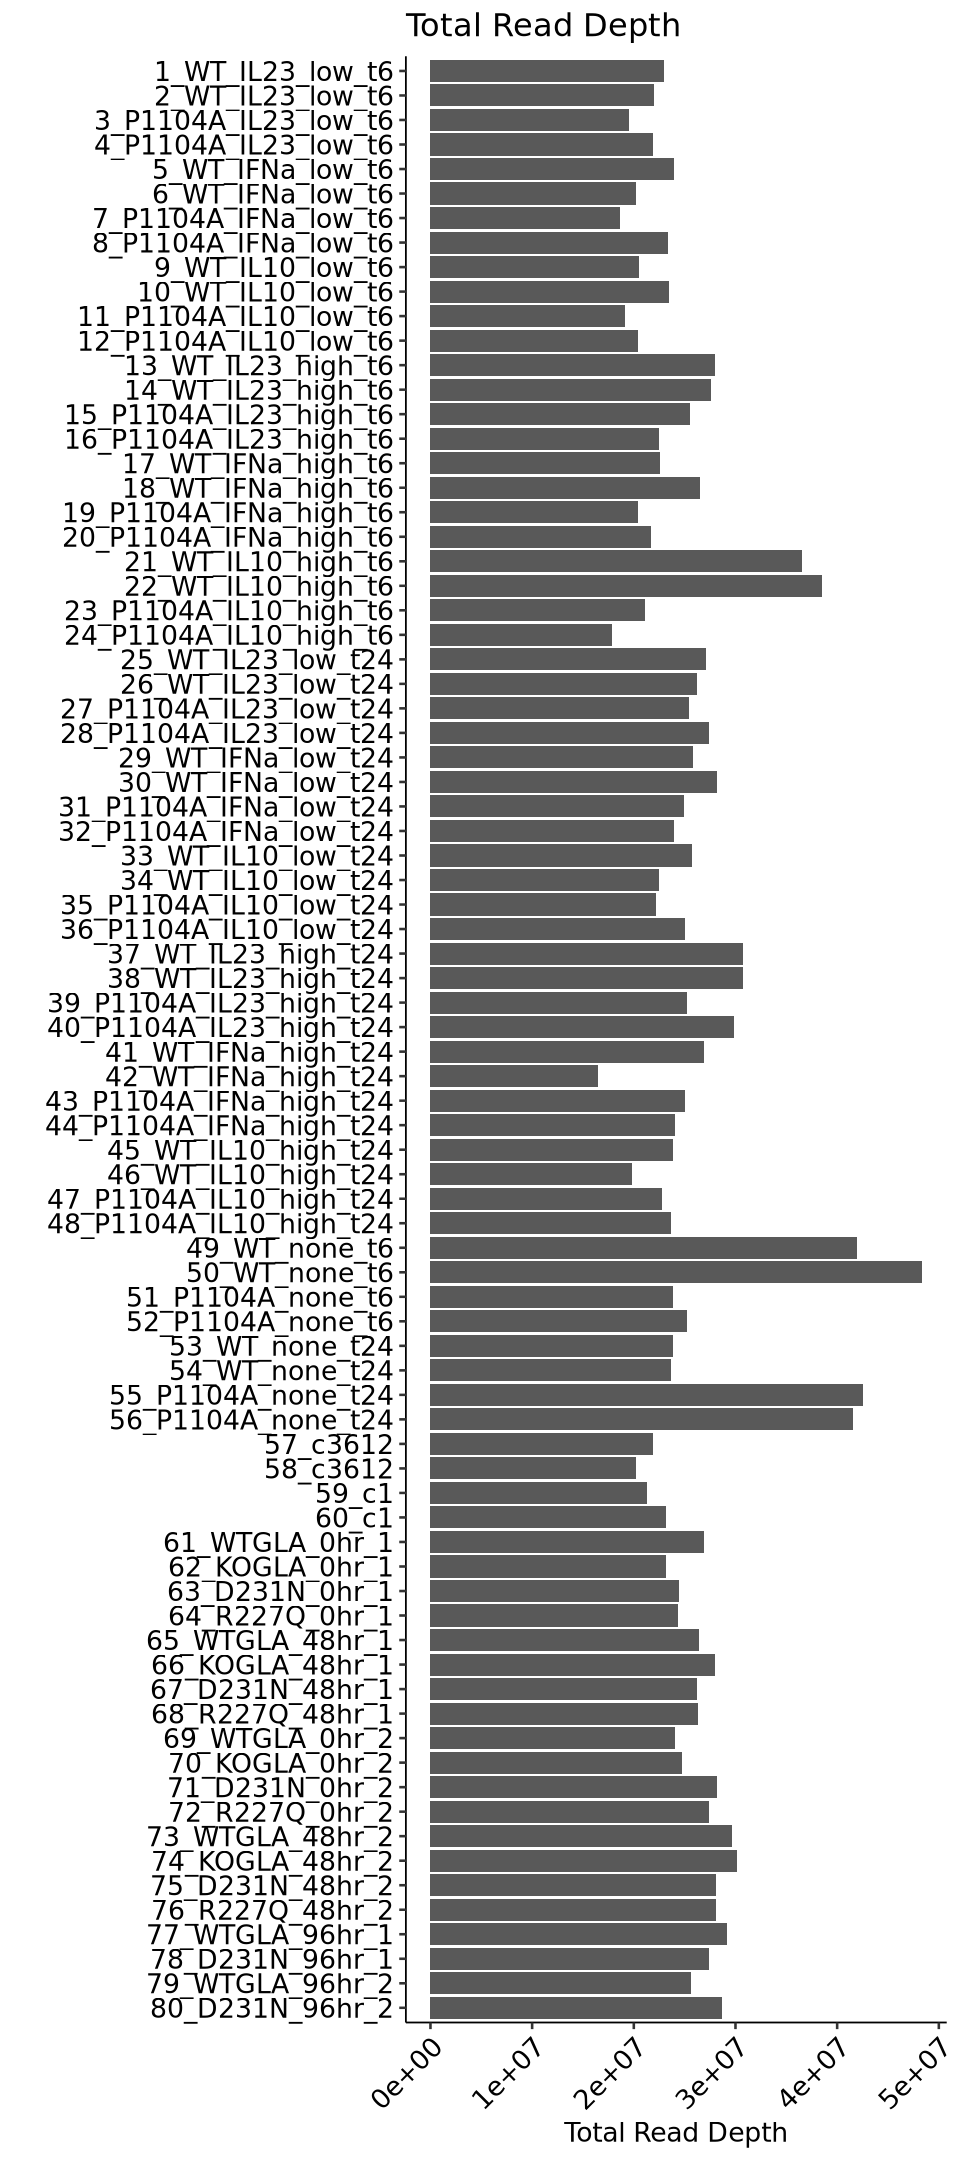

In [5]:
options(repr.plot.width = 8, repr.plot.height = 18)
alignments %>%
    ggplot() +
        geom_bar(aes(x = total_reads, y = reorder(Sample, -id)), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Total Read Depth") + ylab("") +
        ggtitle("Total Read Depth")

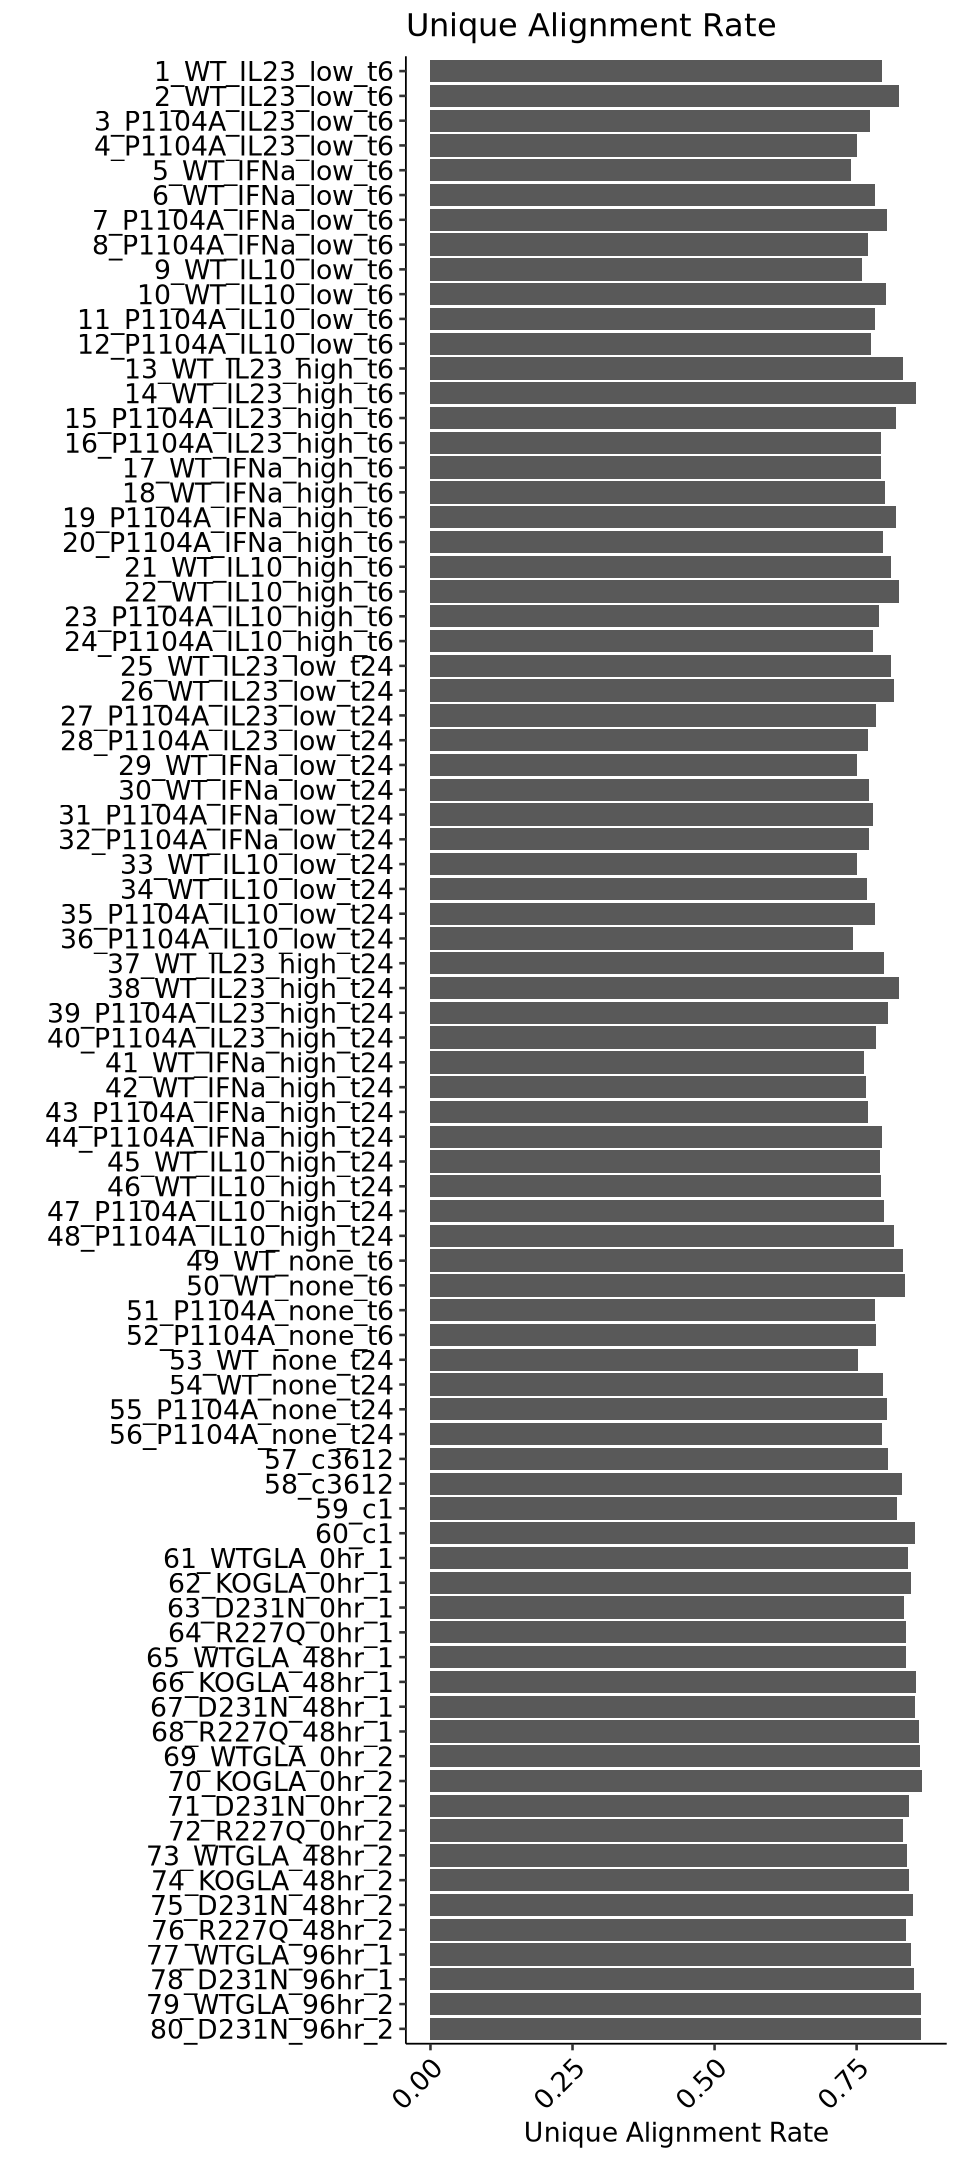

In [6]:
alignments %>%
    ggplot() +
        geom_bar(aes(x = uniquely_mapped_percent/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Unique Alignment Rate") + ylab("") +
        ggtitle("Unique Alignment Rate")

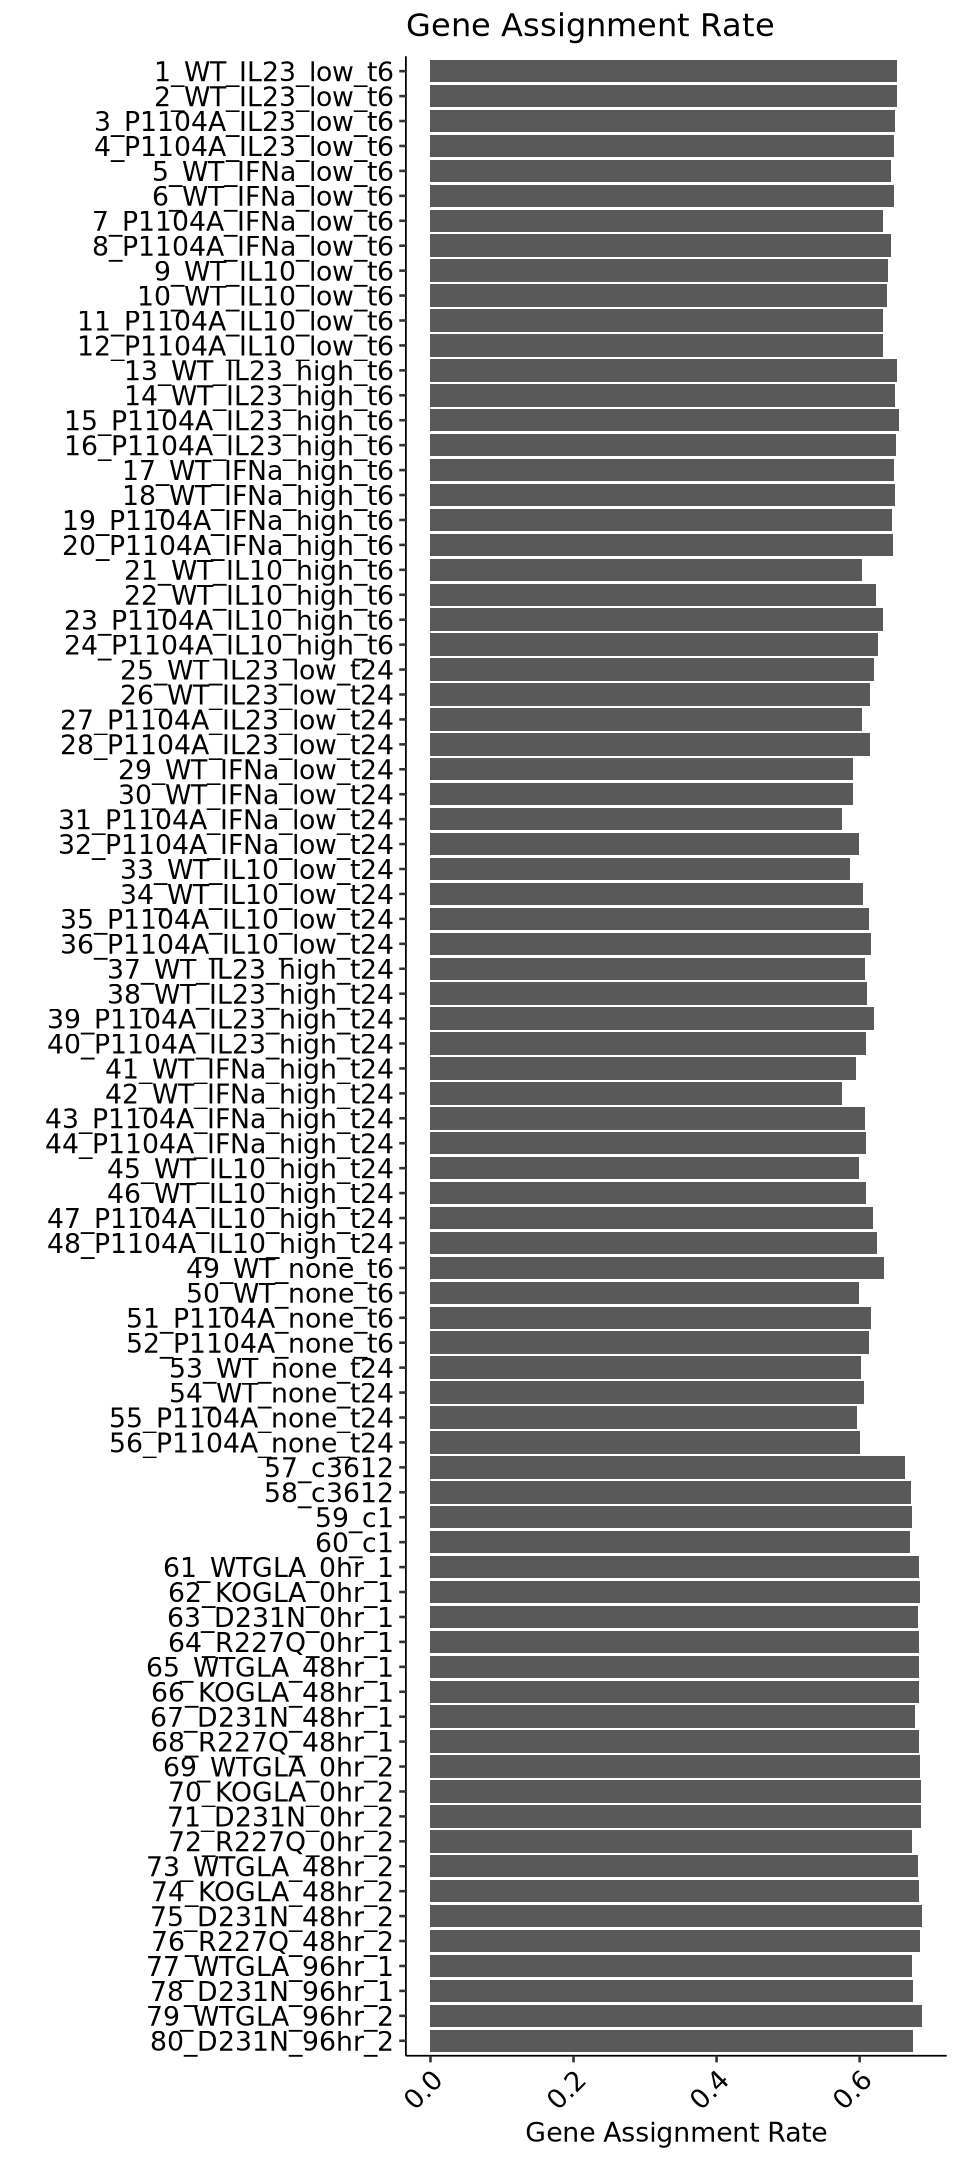

In [7]:
count_summary %>%
    ggplot() +
        geom_bar(aes(x = percent_assigned/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Gene Assignment Rate") + ylab("") +
        ggtitle("Gene Assignment Rate")

#### Unsupervised Profiles <a name="part2"></a>

In [33]:
paths <- str_c("../pipeline/diffexp/",
                    alignments$Sample,
                    ".counts.tsv")
names(paths) <- paths

df <- map_dfr(paths,
              ~read_tsv(.x,
                        col_names = NULL,
                        skip = 2,
                        col_select = c(1,7)),
              .id = "sample") %>%
    rename("gene" = "X1",
           "count" = "X7") %>%
    mutate(sample = gsub("../pipeline/diffexp/|.counts.tsv", "", sample))

df_id <- df %>%
    mutate(id = as.character(gsub("_.*", "", sample))) %>%
    select(-sample) %>%
    arrange(id)

Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────

In [44]:
samp_prop <- read_tsv("../sumstats/RNASEQ/run2/sample-properties-il23.tsv") %>%
    arrange(sample_id) %>%
    mutate(rep = rep(c(1,2), 40),
           covariate = as.factor(str_c(group, "_", cytokine, "_", dosage, "_", time)),
           sample_id = as.character(sample_id))
rownames(samp_prop) <- samp_prop$sample_id

Rows: 80 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): group, cytokine, dosage, time
dbl (1): sample_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [45]:
cor_data_wide <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(!is.na(covariate)) %>%
    arrange(time, group, cytokine, dosage, rep) %>%
    select(gene, covariate, rep, count) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

cor_data_wide$v <- rowMeans(as.matrix(cor_data_wide[,-1]), na.rm = TRUE)

cor_data_filt <- cor_data_wide %>%
    arrange(-v) %>%
    head(500) %>%
    select(-gene, -v)

cor_mat <- cor(cor_data_filt, use = "pairwise.complete.obs")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


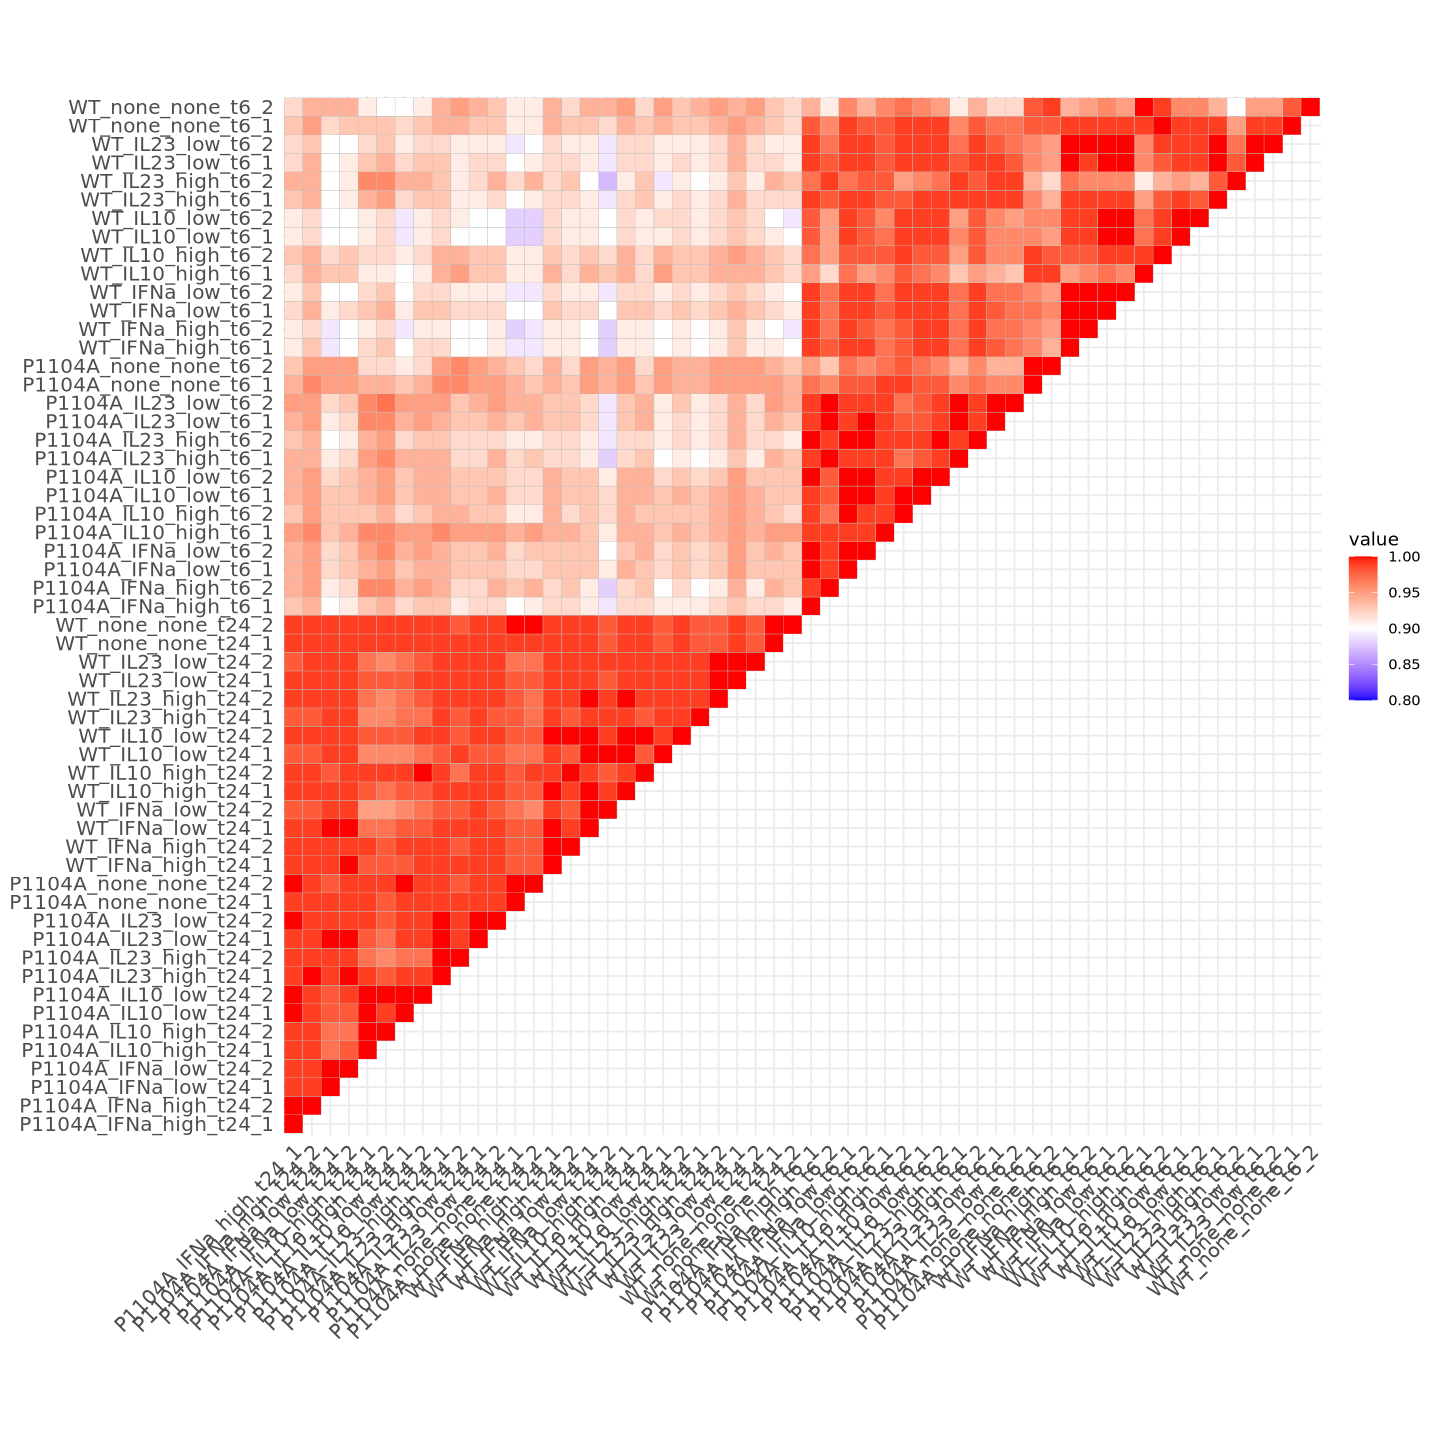

In [46]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggcorrplot(cor_mat, hc.order = FALSE, type = "upper", show.diag = TRUE) +
    scale_fill_gradient2(limit = c(0.8,1), low = "blue", high =  "red", mid = "white", midpoint = 0.9)

#### Statistical Modeling <a name="part3"></a>

In [47]:
de_prop <- samp_prop %>%
    filter(!is.na(cytokine)) %>%
    arrange(covariate)
rownames(de_prop) <- str_c(de_prop$covariate, "_", de_prop$rep)

de_data <- df_id %>%
    inner_join(de_prop %>% select(sample_id, covariate, rep), by = c("id" = "sample_id")) %>%
    select(-id) %>%
    filter(!is.na(covariate)) %>%
    arrange(covariate, rep) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

log2_cpm <- de_data %>%
    pivot_longer(names_to = "sample", values_to = "count", -gene) %>%
    group_by(sample) %>%
    mutate(count = log2(count * 1000000 / sum(count, na.rm = TRUE)),
           count = if_else(is.infinite(count), NA, count)) %>%
    pivot_wider(names_from = sample, values_from = count)

write_tsv(de_data, "../sumstats/RNASEQ/run2/combined/raw-counts.tsv")
write_tsv(log2_cpm, "../sumstats/RNASEQ/run2/combined/log2-cpm.tsv")

Warning message:
“Setting row names on a tibble is deprecated.”


In [48]:
deobj_counts <- DESeqDataSetFromMatrix(countData = de_data %>% select(-gene),
    colData = de_prop,
    design = ~covariate)

deresult <- DESeq(deobj_counts)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [49]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate) %>%
    as.character()

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group) %>%
    as.character()

plan(multicore, workers = 25)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y),
                             independentFiltering = FALSE))

sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = de_data$gene,
                                            as_tibble(.x),
                                            "condition" = .y))

sumstats %>%
    separate(condition, c("background", "cytokine", "dosage", "time"), "_") %>%
    write_tsv("../sumstats/RNASEQ/run2/combined/deseq2-sumstats-vs-none.tsv")

Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

In [52]:
sumstats <- read_tsv( "../sumstats/RNASEQ/run2/combined/deseq2-sumstats-vs-none.tsv.gz")
split_sumstats <- sumstats %>%
    mutate(group = case_when(padj == 1 ~ "FDR = 1",
                             padj < 0.01 ~ "FDR < 0.01",
                             TRUE ~ "NS")) %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low"))

ma_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2(baseMean),
                       y = log2FoldChange,
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

Rows: 1454568 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene, background, cytokine, dosage, time
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


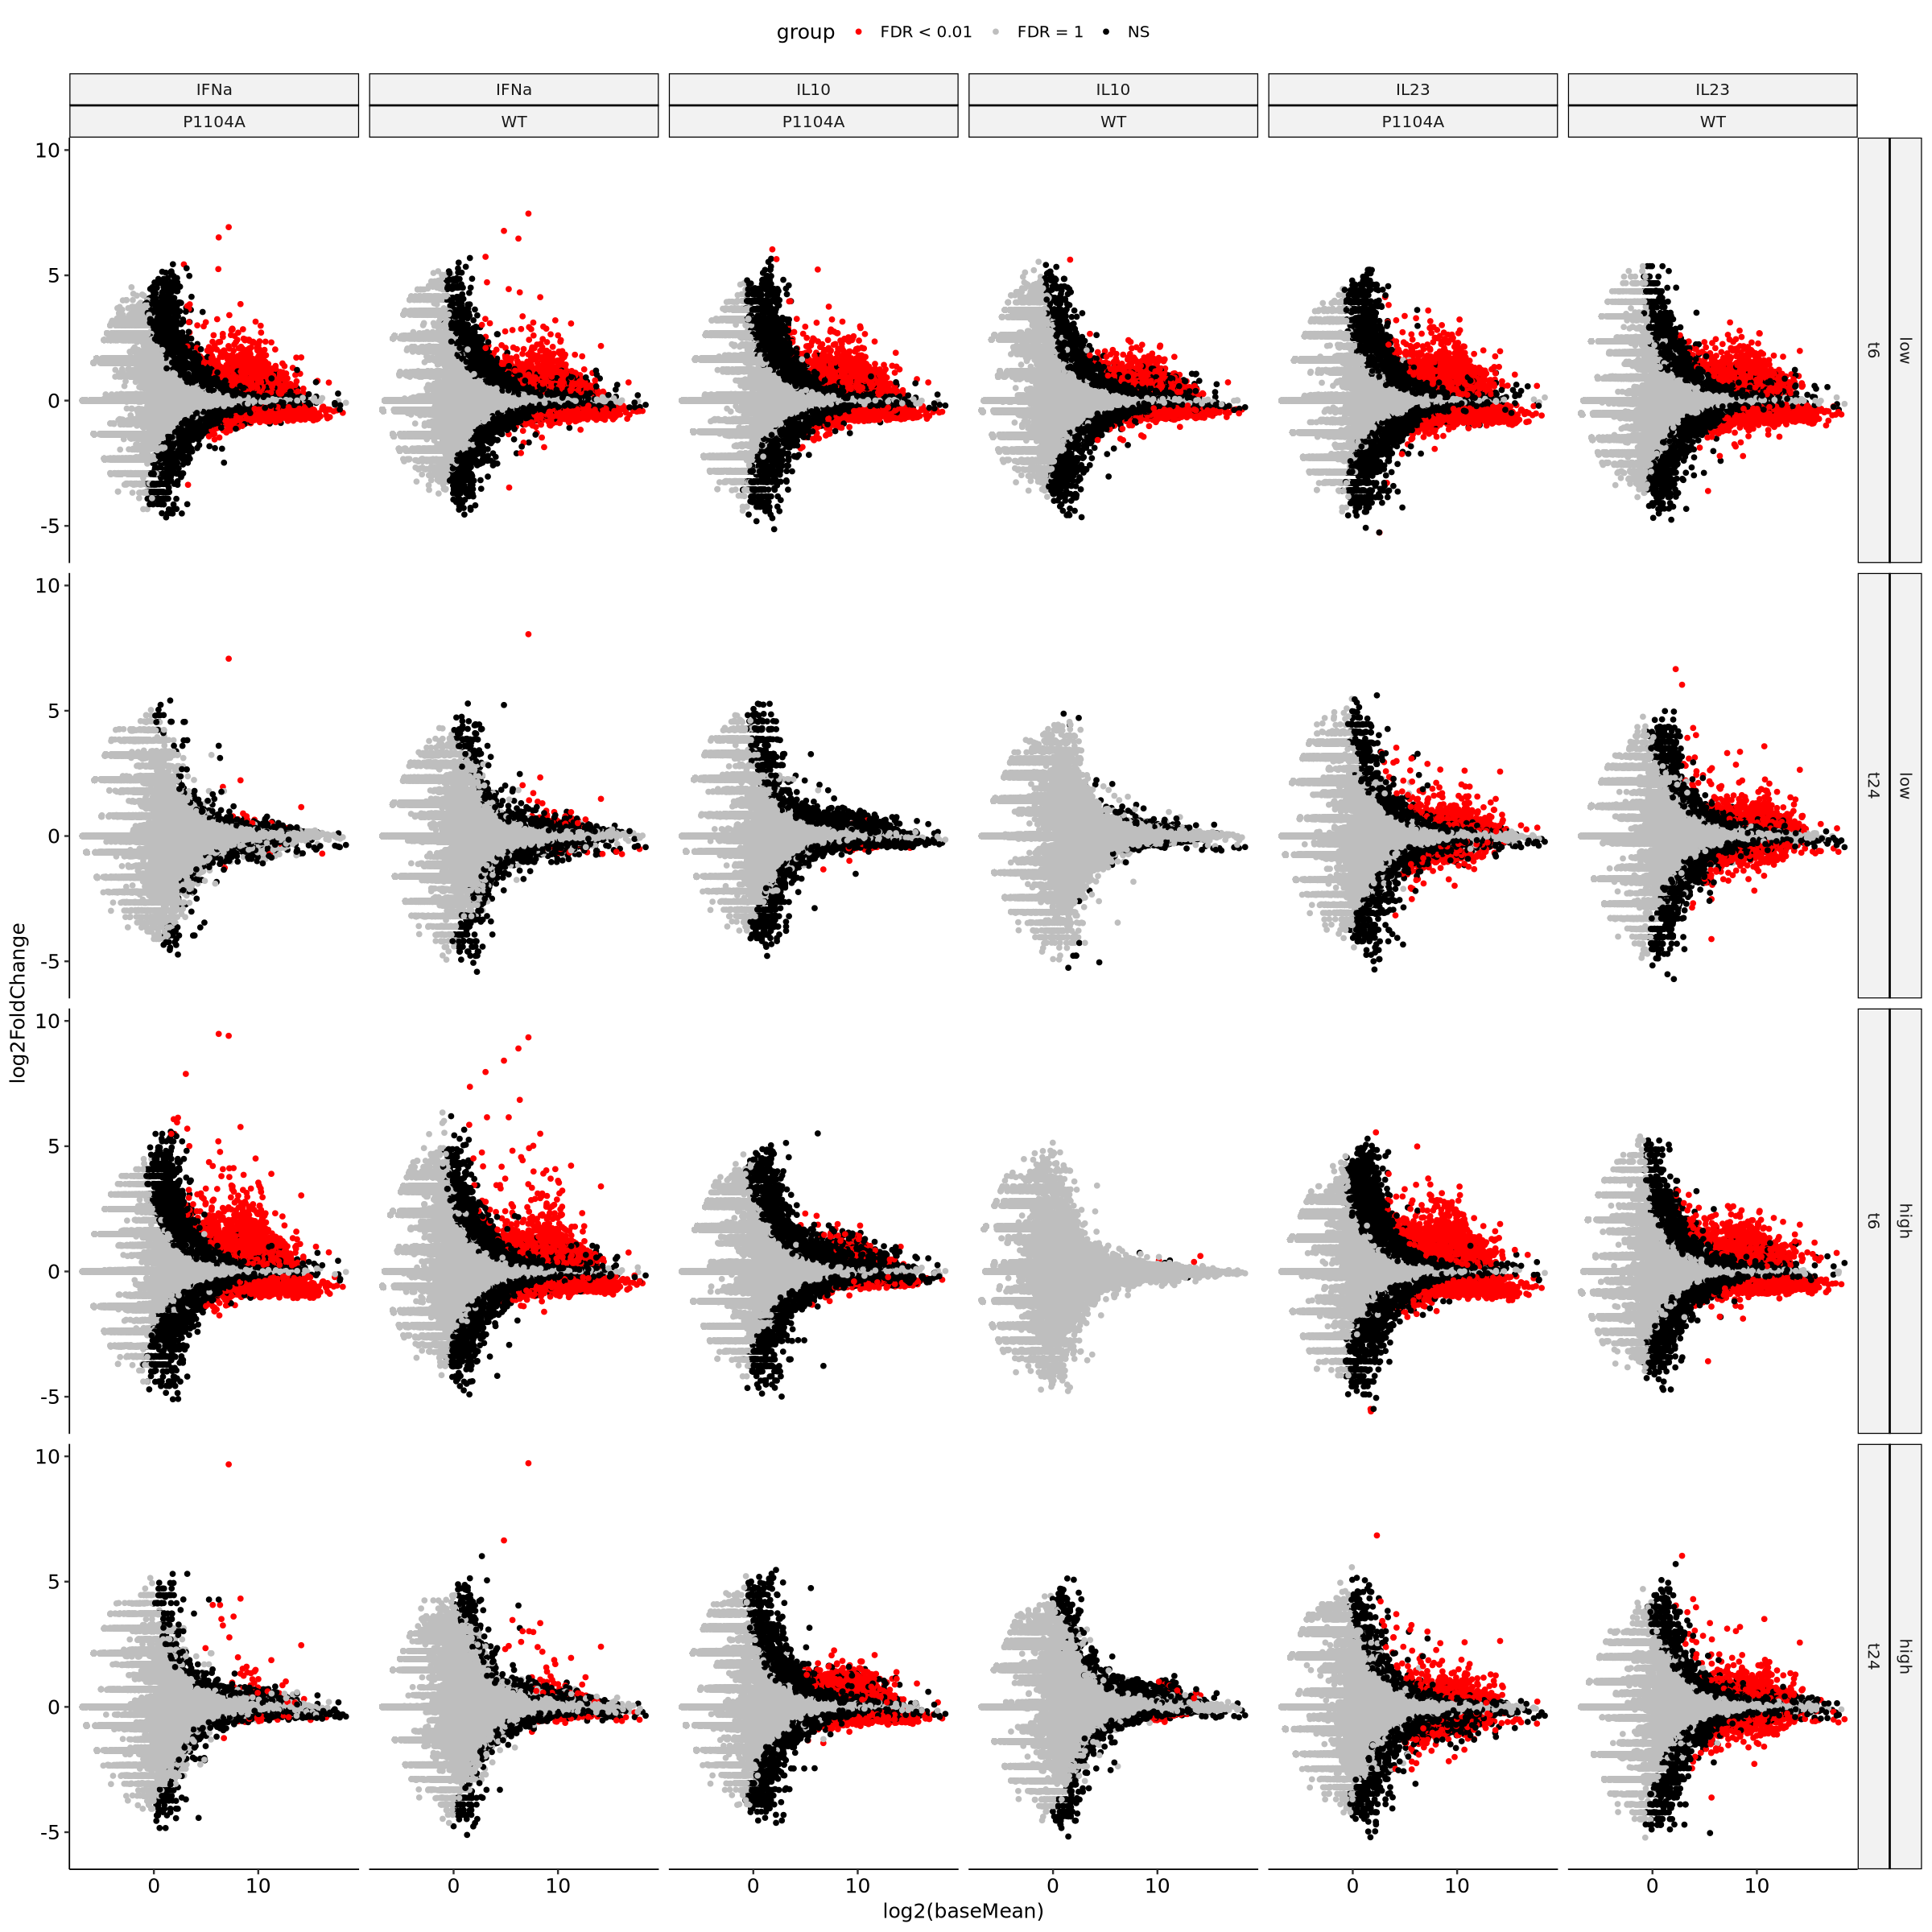

In [53]:
options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
ma_grid

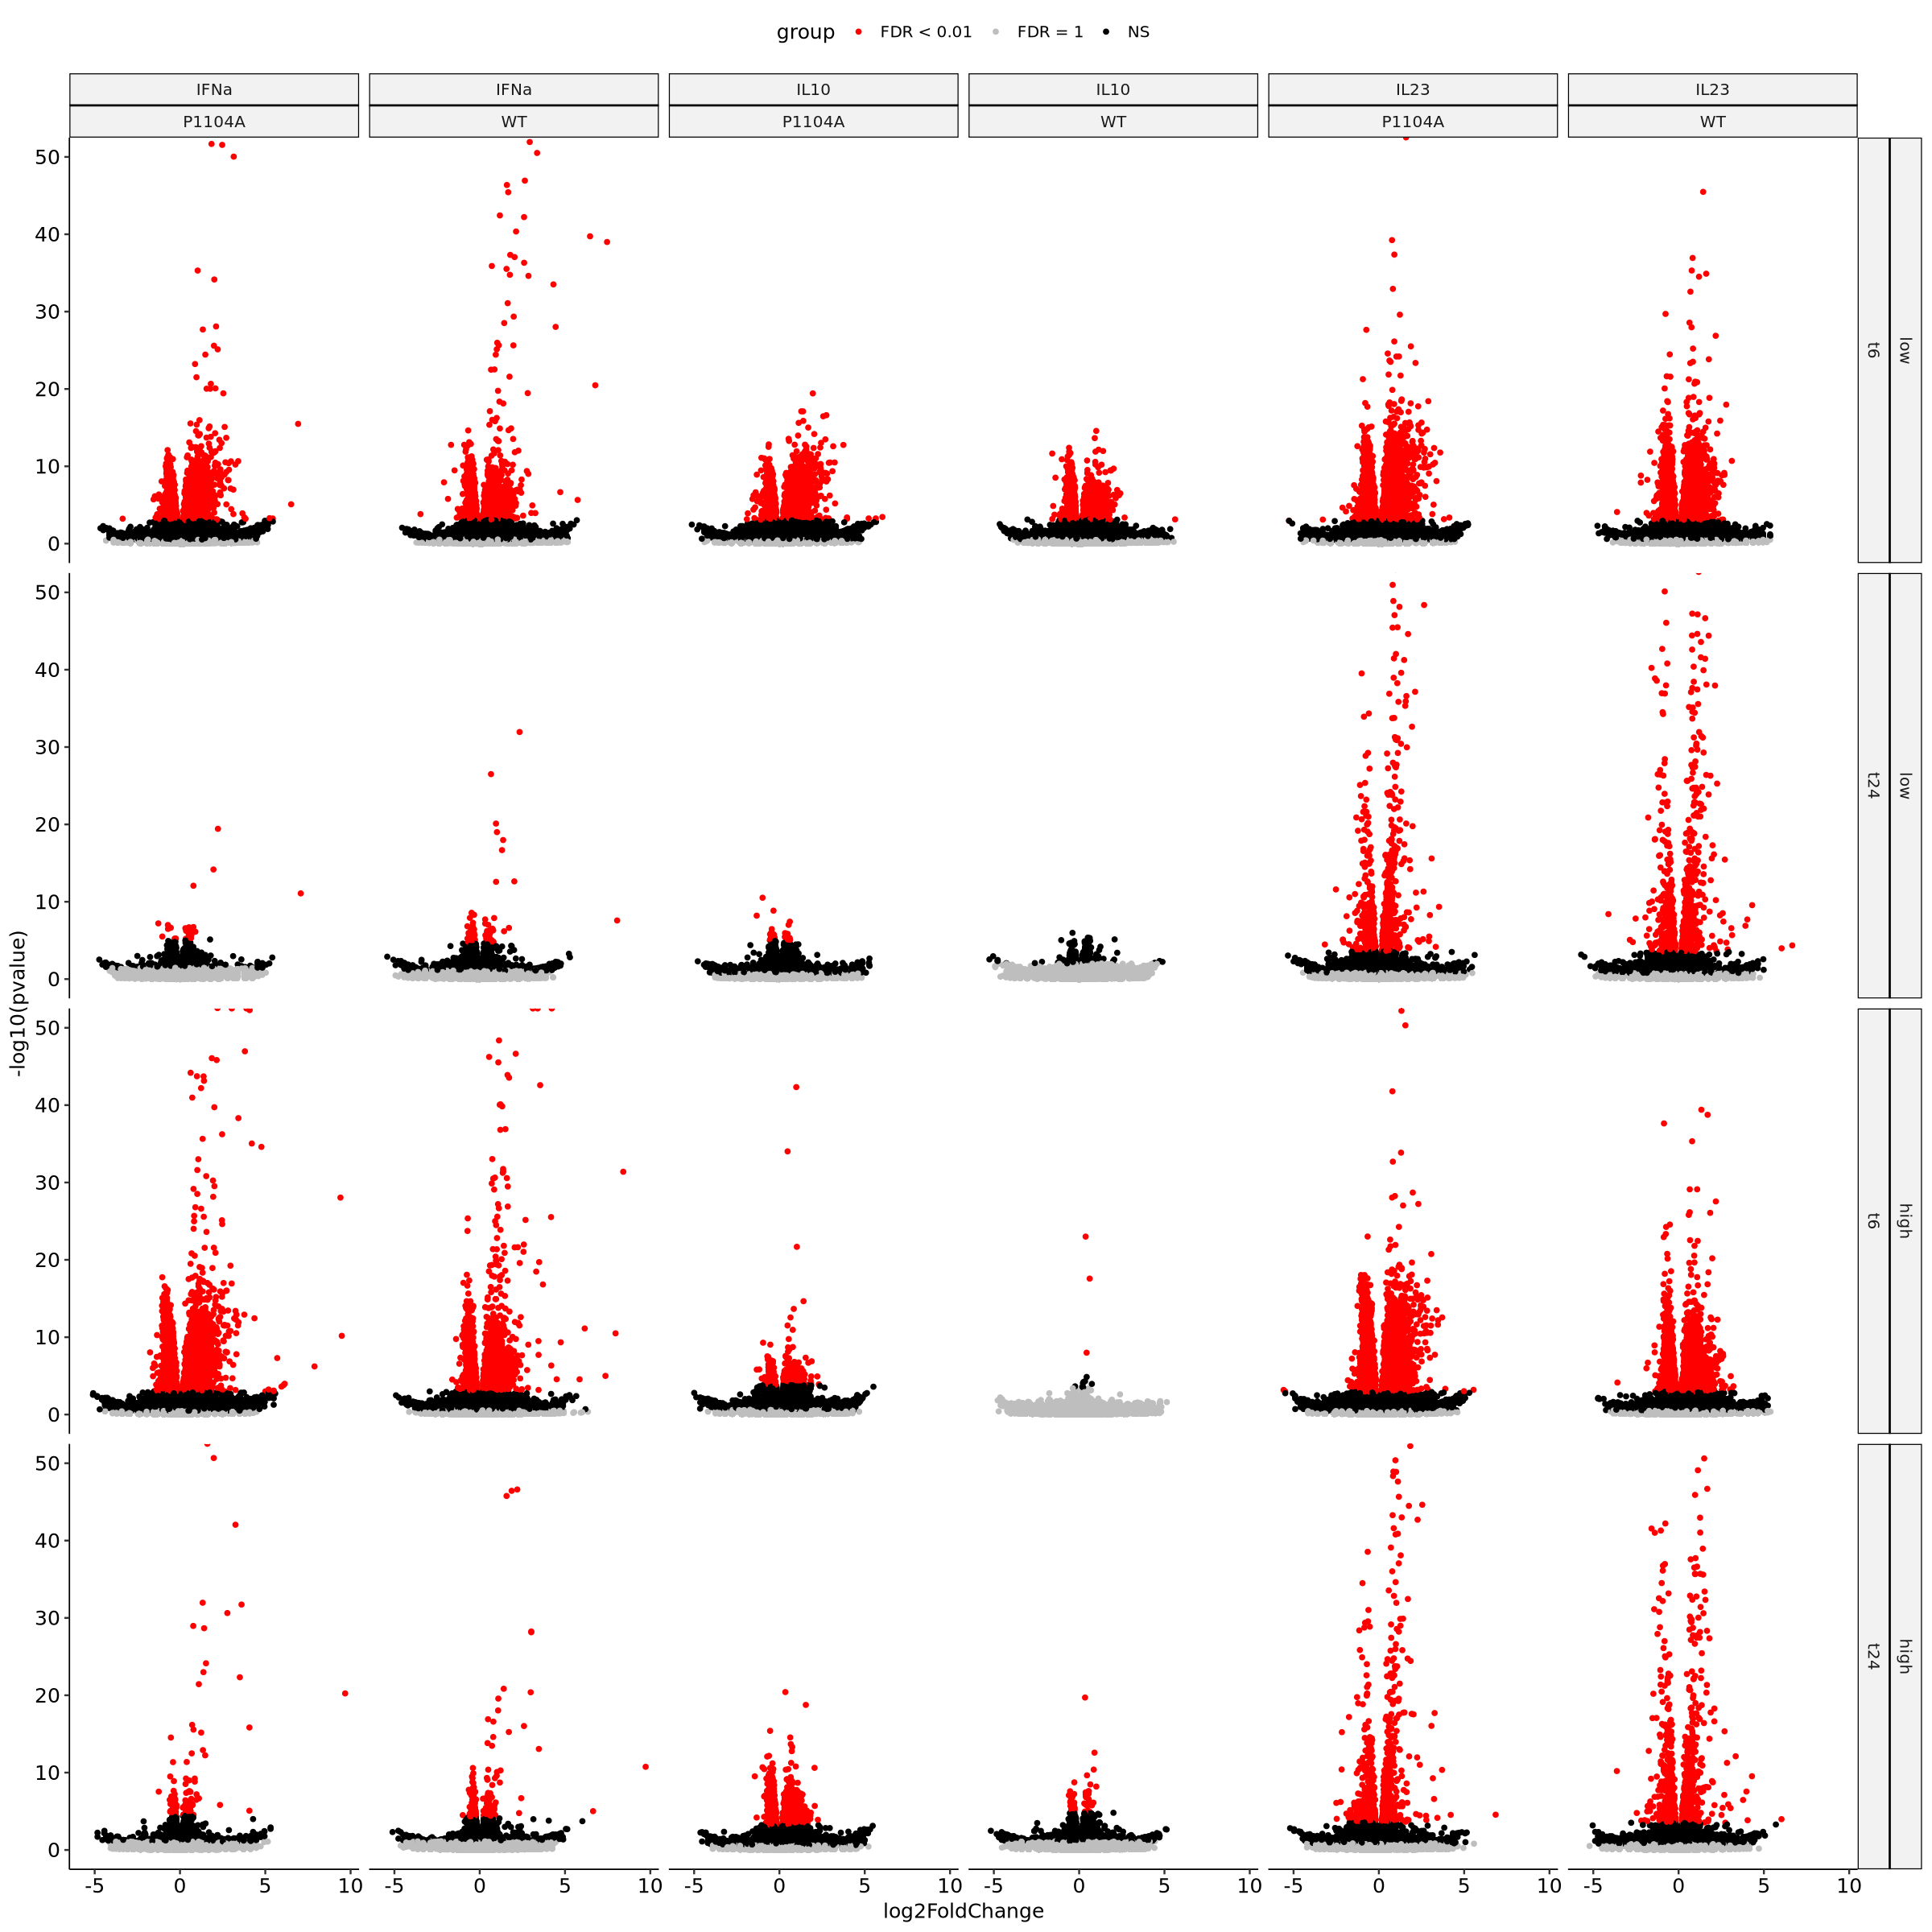

In [54]:
volcano_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange,
                       y = -log10(pvalue),
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red")) +
        coord_cartesian(ylim = c(0, 50))

options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
volcano_grid

#### Differentially Expressed Genes <a name="part4"></a>

In [56]:
vsd <- assay(vst(deresult, blind = FALSE))
vsd <- cbind(vsd, "row_var" = rowVars(vsd, na.rm = TRUE))

vsd_gene <- bind_cols("gene" = de_data$gene,
                      vsd) %>%
    pivot_longer(names_to = "sample", values_to = "norm_value", P1104A_IFNa_high_t24_1:WT_none_none_t6_2) %>%
    inner_join(de_prop %>% mutate(sample_id = str_c(covariate, "_", rep)),
               by = c("sample" = "sample_id")) %>%
    arrange(cytokine, group, dosage, time, rep)

var_genes <- vsd_gene %>%
    select(gene, row_var) %>%
    distinct() %>%
    arrange(-row_var) %>%
    head(500) %>%
    pull(gene)

vsd_gene_wide_sig <- vsd_gene %>%
    filter(gene %in% var_genes) %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_gene_wide_all <- vsd_gene %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_format <- vsd_gene_wide_all
names(vsd_format)[-1] <- gsub(" ", "_", names(vsd_format)[-1])
vsd_format %>% write_tsv("../sumstats/RNASEQ/run2/combined/deseq2-variance-stabilized-quants.tsv")

Loading required namespace: magick



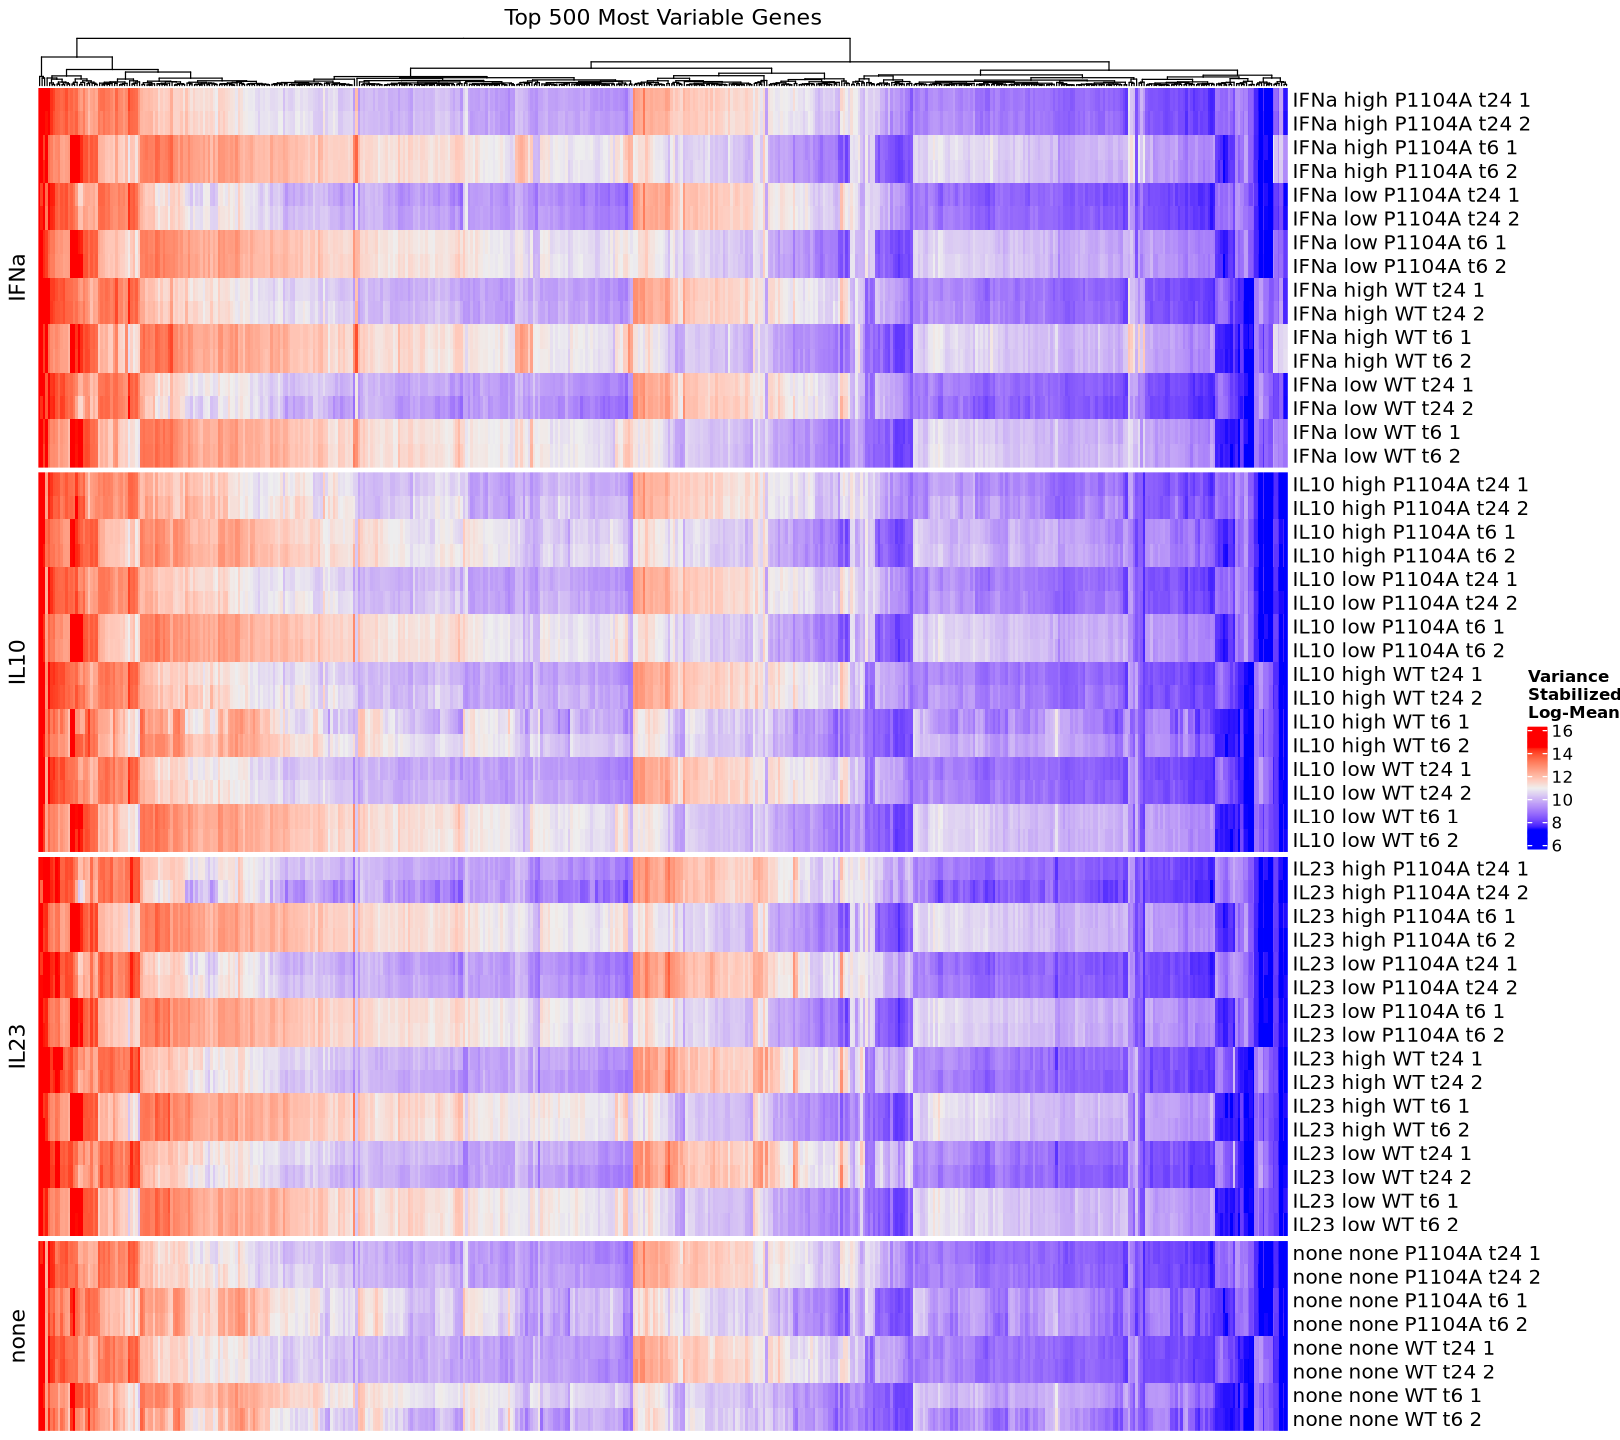

In [57]:
options(repr.plot.width = 13.5, repr.plot.height = 12)
Heatmap(t(as.matrix(vsd_gene_wide_sig[,-1])),
        column_title = "Top 500 Most Variable Genes",
        cluster_columns = TRUE,
        cluster_rows = FALSE,
        row_split = gsub(" .*", "", names(vsd_gene_wide_sig[,-1])),
        use_raster = TRUE,
        raster_by_magick = TRUE,
        name = "Variance\nStabilized\nLog-Mean")